In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats 
%matplotlib inline

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-24' and '2023-01-30'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [3]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


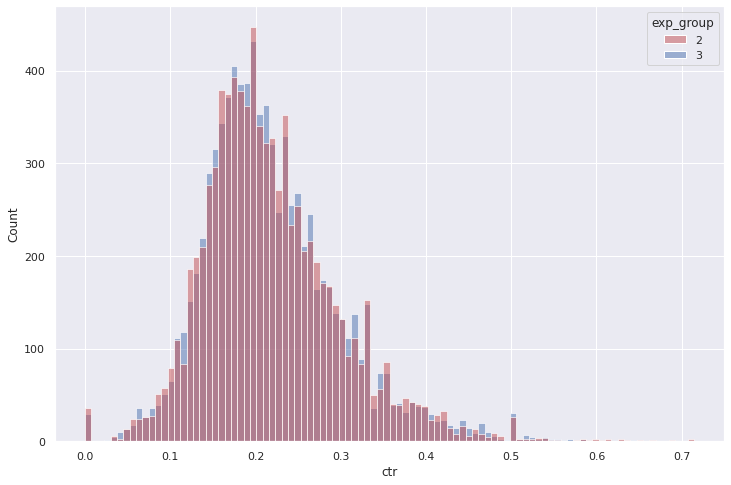

In [4]:
sns.set(rc={'figure.figsize':(12,8)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Сделаем симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации формируем подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Проводим сравнение этих подвыборок t-testом.  

In [5]:
pvale_df = pd.DataFrame(columns=['pvalue'])

for _ in range(10000):
    df_2 = df[df.exp_group == 2].ctr.sample(500).reset_index()
    df_3 = df[df.exp_group == 3].ctr.sample(500).reset_index()
    pvale_df.loc[len(pvale_df.index)] = [stats.ttest_ind(df_2.ctr, df_3.ctr, equal_var=False).pvalue]

Строим гистограмму распределения получившихся 10000 p-values.

<AxesSubplot:xlabel='pvalue', ylabel='Count'>

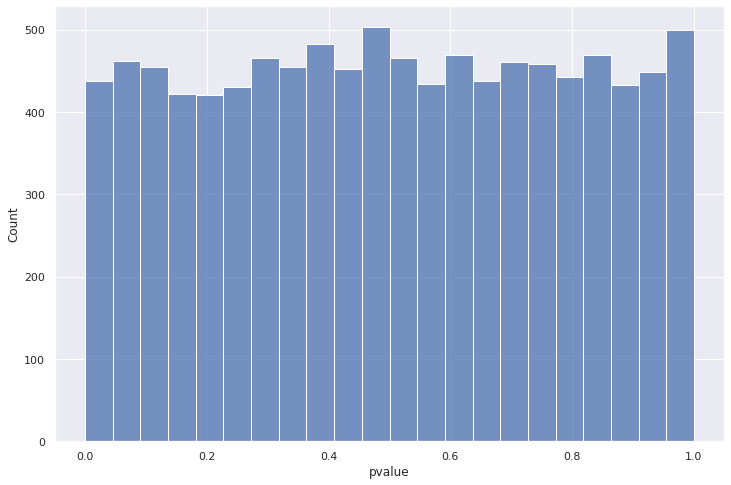

In [6]:
sns.histplot(pvale_df.pvalue)

In [7]:
pvale_df.pvalue.describe()

count    10000.000000
mean         0.503838
std          0.287920
min          0.000291
25%          0.262260
50%          0.501418
75%          0.751954
max          0.999982
Name: pvalue, dtype: float64

Посчитаем, какой процент p values оказался меньше либо равен 0.05

In [8]:
pvale_df.loc[pvale_df.pvalue <= 0.05].count() * 100 / pvale_df.count()

pvalue    4.89
dtype: float64



Можно заметить, что менее 5 % от всех получившихся значений pvalue находятся ниже, либо равны 0.05. Исходя из этого можно сделать вывод, что наша система сплитования работает корректно и можно переходить к стадии А/В тестирования. 